### Section A
#### 1.

The PDF of stress factor x is given by:

$$ p(x|\theta) = \frac{1}{\pi}\frac{1}{1 + (x - \theta)^2} \quad, $$

where theta is an unknown constant. We assume that the samples $ D_j , j = 1, 2 $ are Independent Identically Distributed
(i.i.d.) i.e.  they have been drawn independently from the same distribution $ p(x|\theta_j, \omega_j) $. Therefore the 
common PDF from the samples is:

$$ p(D_j | \theta_j) = \prod_{i=1}^{N_j} p(x_i | \theta_j), \quad j = 1, 2 \quad. $$

We will use the Maximum Likelihood (ML) Method to estimate the parameters $\hat{\theta}_1, \hat{\theta}_2$. We want to
maximize the log-likelihood function:

$$ L(D_j | \theta_j) = \sum_{i=1}^{N_j} lnp(x_i | \theta_j) = 
-N_j ln\pi - \sum_{i=1}^{N_j} ln(1 + (x_i - \theta_j)^2), \quad j = 1, 2 \quad. $$

with respect to $ \theta_j $.

beta1 = 2.5997956280008183
beta2 = -3.1585776211121144


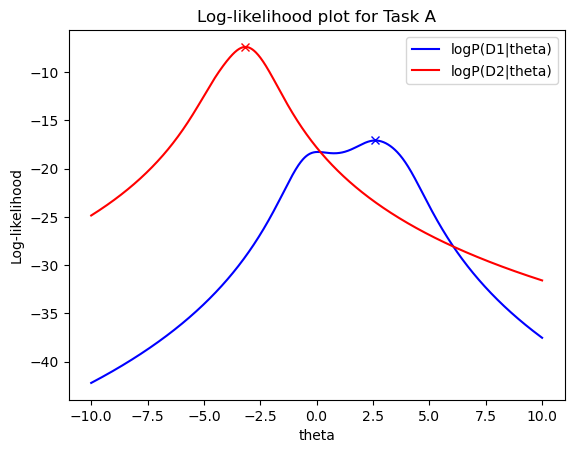

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

D1 = np.array([2.8, -0.4, -0.8, 2.3, -0.3, 3.6, 4.1])  # no stress data
D2 = np.array([-4.5, -3.4, -3.1, -3.0, -2.3])  # stress data

# Log-likelihood function
def logp(theta, D):
    return np.sum(-np.log(np.pi) - np.log(1 + (D - theta)**2))

# Maximize log-likelihood by negating it inline using a lambda function
result = minimize(lambda theta: -logp(theta, D1), x0=2.5, method='BFGS')
beta1 = result.x[0]
print(f'beta1 = {beta1}')
result = minimize(lambda theta: -logp(theta, D2), x0=-2.5, method='BFGS')
beta2 = result.x[0]
print(f'beta2 = {beta2}')


x = np.linspace(-10, 10, 1000)
y1 = np.array([logp(theta, D1) for theta in x])
y2 = np.array([logp(theta, D2) for theta in x])

plt.plot(x, y1, label='logP(D1|theta)', color='blue')
plt.plot(x, y2, label='logP(D2|theta)', color='red')
plt.plot(beta1, logp(beta1, D1), color='blue', marker='x')
plt.plot(beta2, logp(beta2, D2), color='red', marker='x')
plt.xlabel('theta')
plt.ylabel('Log-likelihood')
plt.title('Log-likelihood plot for Task A')
plt.legend()
plt.show()